In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
data = pd.read_csv("Boston.csv")

# Select the features (independent variables) and target (dependent variable)
X = data[['crim', 'indus', 'dis', 'black', 'ptratio', 'lstat', 'zn', 'nox', 'age', 'rad', 'tax']]  # Use 'dis' and 'crim' columns as features
y = data['medv']            # 'medv' column as the target

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the dataset into multiple "clients"
num_clients = 3
data_splits = np.array_split(Xtrain, num_clients)
target_splits = np.array_split(ytrain, num_clients)

/home/derk/Documents/vrije_universiteit/machinelearningsecurity/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/derk/Documents/vrije_universiteit/machinelearningsecurity/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [5]:
attacker_id = 1
# Function to train a local model
def train_local_model(d, t, i):
    model = LinearRegression()
    model.fit(d, t)
    attacked_coef_ = model.coef_
    if (i == attacker_id):
        attacked_coef_ = [0] * len(model.coef_)
    return model.coef_, attacked_coef_, model.intercept_, model.feature_names_in_

# Train local models on each client
models = [train_local_model(d, t, i) for i, (d, t) in enumerate(zip(data_splits, target_splits))]
immune_models = models[:attacker_id] + models[attacker_id+1:]
attacker_model = models[attacker_id]


# Aggregate the coefficients and intercepts (average them)
model_coef_ = np.mean([model[0] for model in immune_models], axis=0)
model_intercept_ = np.mean([model[2] for model in immune_models])
model_feature_names_ = immune_models[0][3]

In [ ]:
# Evaluate the global model
def evaluate_model(global_coef_, attack_coef_, global_intercept_, feature_names):
    model = LinearRegression()
    model.coef_ = global_coef_
    model.intercept_ = global_intercept_
    model.feature_names_in_ = feature_names
    
    attacked_model = LinearRegression()
    attacked_model.coef_ = attack_coef_
    attacked_model.intercept_ = global_intercept_
    attacked_model.feature_names_in_ = feature_names

    y_pred = model.predict(Xtest)
    mse = mean_squared_error(ytest, y_pred)
    r2 = r2_score(ytest, y_pred)
    
    attack_ypred = attacked_model.predict(Xtest)
    attack_mse = mean_squared_error(ytest, attack_ypred)
    attack_r2 = r2_score(ytest, attack_ypred)
    return mse, r2, attack_mse, attack_r2, y_pred, attack_ypred

# Evaluate the global model on the entire dataset
mse, r2, attack_mse, attack_r2, yp, ayp = evaluate_global_model(model_coef_, attacked_model_coef_, model_intercept_,  model_feature_names_)
yt = ytest

# Print the results
print("Federated Linear Regression with Multiple Features:")
print(f"  Global Weights: {model_coef_}")
print(f"  Global Bias: {model_intercept_:.2f}")
print(f"  Mean Squared Error (Global Model): {mse:.2f}")
print(f"  R2: {r2:.2f}")

Federated Linear Regression with Multiple Features:
  Global Weights: [-1.51846637e-01  1.15650635e-02 -1.69125818e+00  9.60129424e-03
 -1.24569167e+00 -8.00597546e-01  4.95100222e-02 -1.94797579e+01
  2.34543535e-02  4.30174545e-01 -1.62781114e-02]
  Global Bias: 70.29
  Mean Squared Error (Global Model): 22.26
  R2: 0.70


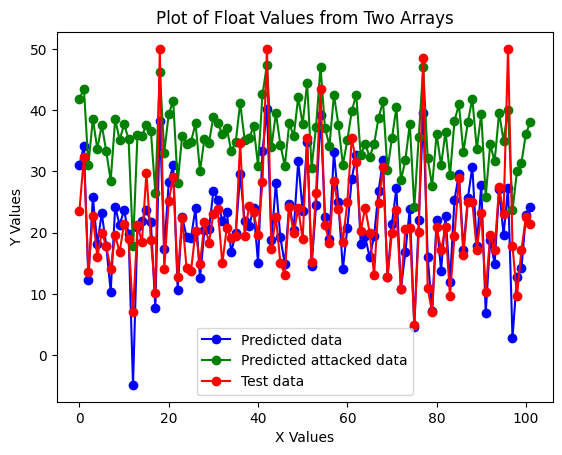

In [63]:
# Plotting the arrays
xarr = np.arange(len(yp))
plt.plot(xarr, yp, marker='o', linestyle='-', color='b', label='Predicted data')
plt.plot(xarr, ayp, marker='o', linestyle='-', color='g', label='Predicted attacked data')
plt.plot(xarr, yt, marker='o', linestyle='-', color='r', label='Test data')

# Adding labels and title
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('Plot of Float Values from Two Arrays')

# Display the legend
plt.legend()

# Show the plot
plt.show()

/tmp/ipykernel_644570/2856719683.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, patch_artist=True, notch=True, vert=True, labels=['Test Data', 'Predicted Data', 'Predicted attacked Data'],


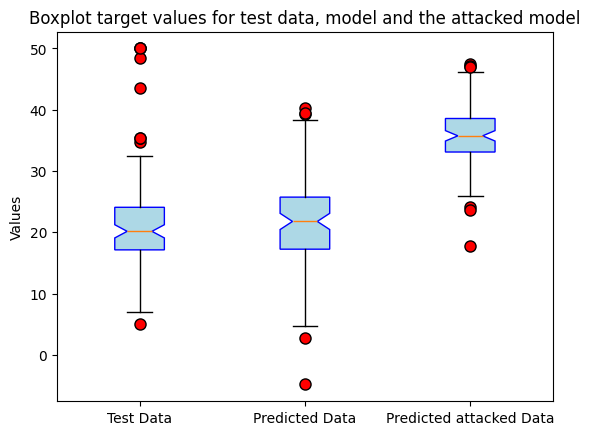

In [70]:
data = [yt, yp, ayp]

# Create the boxplot
plt.boxplot(data, patch_artist=True, notch=True, vert=True, labels=['Test Data', 'Predicted Data', 'Predicted attacked Data'], 
            boxprops=dict(facecolor='lightblue', color='blue'), 
            flierprops=dict(markerfacecolor='red', marker='o', markersize=8))

# Adding labels and title
plt.ylabel('Values')
plt.title('Boxplot target values for test data, model and the attacked model')

# Show the plot
plt.show()

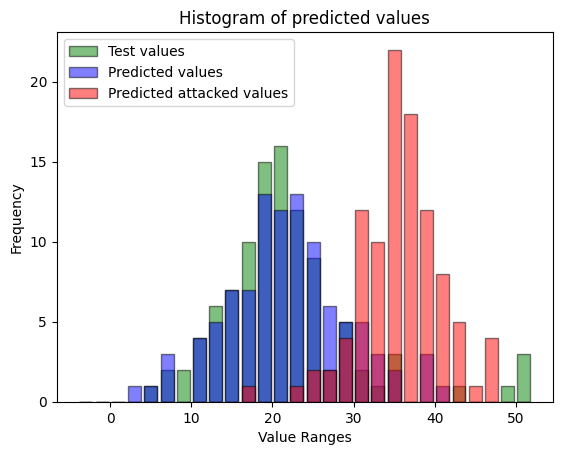

In [69]:
bucket_size = 2
min_value = min(min(yt), min(yp), min(ayp))
max_value = max(max(yt), max(yp), max(ayp))

# Calculate the number of bins (buckets) based on the range of the data
bins = list(range(int(min_value) // bucket_size * bucket_size, int(max_value) // bucket_size * bucket_size + bucket_size * 2, bucket_size))

# Plotting the histogram
plt.hist(yt, bins=bins, edgecolor='black', color='green', alpha=0.5, label='Test values', rwidth=0.8)
plt.hist(yp, bins=bins, edgecolor='black', color='blue', alpha=0.5, label='Predicted values', rwidth=0.8)
plt.hist(ayp, bins=bins, edgecolor='black', color='red', alpha=0.5, label='Predicted attacked values', rwidth=0.8)


# Adding labels and title
plt.xlabel('Value Ranges')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of predicted values')

# Display the plot
plt.show()

